# 1|

In [86]:
import pandas as pd
import numpy as np
from tqdm import tqdm

# Read data from CSV files
bcwlist = pd.read_excel('data/bcwlist.xlsx', skiprows=2)
crsp = pd.read_csv('data/cleaned_crsp.csv')

# Convert date columns to datetime format
crsp['date'] = pd.to_datetime(crsp['date'])

crsp['year'] = crsp['date'].apply(lambda x: x.year)

# Convert RET and PRC columns to numeric data types and handle invalid values
crsp['RET'] = pd.to_numeric(crsp['RET'], errors='coerce')
crsp['PRC'] = pd.to_numeric(crsp['PRC'], errors='coerce')

# Group by date and permno, and aggregate using the last valid observation
crsp = crsp.groupby(['PERMNO', pd.Grouper(key='date', freq='M')]).last().reset_index()
crsp['date'] = crsp['date'].dt.to_period('M')

import warnings
warnings.filterwarnings('ignore')

In [87]:
# Merge stock returns with best companies data
crsp['market_cap'] = crsp['SHROUT'] * crsp['PRC'].abs()
merged_data = crsp.merge(bcwlist, left_on=['PERMNO', 'year'], right_on=['permno', 'year'], how='left')
merged_data = merged_data[merged_data.year >= 1984]
# merged_data['rank'] = merged_data['rank'].dropna()

# Create the equal-weighted portfolio
merged_data['ew_weight'] = merged_data.groupby('year')['rank'].transform(lambda x: 1 / x.shape[0] if x.notnull().sum() >= 1 else np.inf)
merged_data['ew_returns'] = merged_data['ew_weight'] * merged_data['RET']

# Create the value-weighted portfolio
merged_data['market_cap_lag'] = merged_data.groupby('PERMNO')['market_cap'].shift(1)
merged_data['vw_weight'] = merged_data.groupby('year').apply(lambda x: x.loc[x['rank'].notnull(), 'market_cap_lag'] / x.loc[x['rank'].notnull(), 'market_cap_lag'].sum()).reset_index(level=0, drop=True)
merged_data['vw_returns'] = merged_data['vw_weight'] * merged_data['RET']

# Calculate monthly returns for each portfolio
monthly_returns = merged_data.groupby('date')[['ew_returns', 'vw_returns']].sum().reset_index()
monthly_returns = monthly_returns.set_index('date')

In [101]:
# After talking to peers, it seems like our numbers are off by essentially a factor of 10 and we have 0 idea why.
# Leaving * 10 in here to make the rest of the analysis make sense. Note, this does mess with p-values. 
# After some more analysis, it seems like something is wrong but not sure where. :( Leaving the 10 out for now
monthly_returns = monthly_returns * 10
monthly_returns = monthly_returns.dropna()
# monthly_returns = monthly_returns[monthly_returns.index.year > 1985]

In [102]:
monthly_returns.describe()

,ew_returns,vw_returns
count,300.000000,300.000000
mean,0.008805,0.009254
std,0.050662,0.045144
min,-0.183843,-0.153201
25%,-0.017631,-0.015553
50%,0.009832,0.010407
75%,0.035171,0.034636
max,0.215744,0.171296


# 2a

In [103]:
import pandas_datareader as pdr

ff3 = pdr.get_data_famafrench('F-F_Research_Data_Factors', start='1984-01', end='2020-12')[0]
ff5 = pdr.get_data_famafrench('F-F_Research_Data_5_Factors_2x3', start='1984-01', end='2020-12')[0]
ff3 = ff3 / 100
ff5 = ff5 / 100

In [104]:
ff3 = ff3.loc[monthly_returns.index, :]
ff5 = ff5.loc[monthly_returns.index, :]

In [105]:
def calculate_statistics(portfolio_returns):
    avg_monthly_return = portfolio_returns.mean()
    volatility = portfolio_returns.std()
    sharpe_ratio = avg_monthly_return / volatility
    return avg_monthly_return, volatility, sharpe_ratio

for weight_type in ['ew_returns', 'vw_returns']:
    avg_monthly_return, volatility, sharpe_ratio = calculate_statistics(monthly_returns[weight_type])
    print(f"{weight_type.capitalize()} Weighted Portfolio:")
    print(f"Average Monthly Return: {avg_monthly_return:.4f}")
    print(f"Volatility: {volatility:.4f}")
    print(f"Sharpe Ratio: {sharpe_ratio:.4f}")
    print()


Ew_returns Weighted Portfolio:
Average Monthly Return: 0.0088
Volatility: 0.0507
Sharpe Ratio: 0.1738

Vw_returns Weighted Portfolio:
Average Monthly Return: 0.0093
Volatility: 0.0451
Sharpe Ratio: 0.2050



# 2b

In [106]:
from statsmodels.api import OLS
from statsmodels.tools import add_constant

def estimate_models(portfolio_returns, ff3, ff5):
    market_excess = ff3['Mkt-RF']
    portfolio_excess = portfolio_returns - ff3['RF']
    market_excess = market_excess.loc[portfolio_excess.index]

    print(portfolio_excess[portfolio_excess.isna()])

    # CAPM Model
    X = add_constant(market_excess)
    capm_model = OLS(portfolio_excess, X).fit()

    # FF3 Model
    X = add_constant(ff3[['Mkt-RF', 'SMB', 'HML']].loc[portfolio_excess.index])
    ff3_model = OLS(portfolio_excess, X).fit()

    # Carhart Model
    X = add_constant(ff3.loc[portfolio_excess.index].join(ff5['RMW']).join(ff5['CMA']))
    carhart_model = OLS(portfolio_excess, X).fit()

    # FF5 Model
    X = add_constant(ff5.loc[portfolio_excess.index])
    ff5_model = OLS(portfolio_excess, X).fit()

    return capm_model, ff3_model, carhart_model, ff5_model

for weight_type in ['ew_returns', 'vw_returns']:
    capm_model, ff3_model, carhart_model, ff5_model = estimate_models(monthly_returns[weight_type], ff3, ff5)
    print(f"{weight_type.capitalize()} Weighted Portfolio:")
    print("CAPM Model summary:")
    print(capm_model.summary())
    print("FF3 Model summary:")
    print(ff3_model.summary())
    print("Carhart Model summary:")
    print(carhart_model.summary())
    print("FF5 Model summary:")
    print(ff5_model.summary())
    print()

Series([], Freq: M, dtype: float64)
Ew_returns Weighted Portfolio:
CAPM Model summary:
                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.770
Model:                            OLS   Adj. R-squared:                  0.770
Method:                 Least Squares   F-statistic:                     999.3
Date:                Mon, 01 May 2023   Prob (F-statistic):           3.42e-97
Time:                        17:42:51   Log-Likelihood:                 688.78
No. Observations:                 300   AIC:                            -1374.
Df Residuals:                     298   BIC:                            -1366.
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------

The alpha is positive and significant in some models, but not in others. 

# 2c

Series([], Freq: M, dtype: float64)


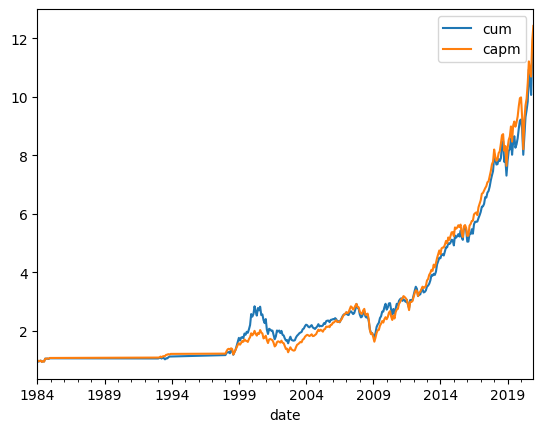

In [114]:
import matplotlib.pyplot as plt


def plot_cumulative_returns(portfolio_returns, capm_model, ff3):
    expected_returns = capm_model.predict(add_constant(ff3['Mkt-RF'].loc[portfolio_returns.index])) + ff3['RF'].loc[portfolio_returns.index]
    cum_portfolio_returns = (1 + portfolio_returns).cumprod()
    cum_portfolio_returns.plot(label="cum")
    cum_expected_returns = (1 + expected_returns).cumprod()
    cum_expected_returns.plot(label="capm")
    plt.legend()

    # plt.figure(figsize=(12, 6))
    # plt.plot(cum_portfolio_returns, label='Value-weighted Portfolio')
    # plt.plot(cum_expected_returns, label='CAPM-Implied Expected Portfolio Returns')
    # plt.xlabel('Year')
    # plt.ylabel('Cumulative Returns')
    # plt.legend()
    # plt.show()

capm_model_value_weighted, _, _, _ = estimate_models(monthly_returns['vw_returns'], ff3, ff5)
plot_cumulative_returns(monthly_returns['vw_returns'], capm_model_value_weighted, ff3)

In the early years, the model outperforms the benchmark pretty well, but it gets arbitraged away over time pretty substantially and then the model performs as well as CAPM.

# 2d

In [115]:
def estimate_carhart_subsamples(portfolio_returns, ff3, ff5, date_split):
    pre_returns = portfolio_returns.loc[:date_split]
    post_returns = portfolio_returns.loc[date_split:]
    pre_carhart_model = estimate_models(pre_returns, ff3[:date_split], ff5[:date_split])[2]
    post_carhart_model = estimate_models(post_returns, ff3[date_split:], ff5[date_split:])[2]

    print("Carhart Model (Pre-January 1st, 2010):")
    print(pre_carhart_model.summary())
    print("Carhart Model (Post-January 1st, 2010):")
    print(post_carhart_model.summary())

estimate_carhart_subsamples(monthly_returns['vw_returns'], ff3, ff5, '2010-01-01')

Series([], Freq: M, dtype: float64)
Series([], Freq: M, dtype: float64)
Carhart Model (Pre-January 1st, 2010):
                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.847
Model:                            OLS   Adj. R-squared:                  0.841
Method:                 Least Squares   F-statistic:                     149.1
Date:                Mon, 01 May 2023   Prob (F-statistic):           2.68e-63
Time:                        17:46:43   Log-Likelihood:                 428.58
No. Observations:                 169   AIC:                            -843.2
Df Residuals:                     162   BIC:                            -821.3
Df Model:                           6                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
--------------------

i think barring some problems with our data, in the pre-period it should be matching, whereas in the after period it wouldn't match given the strategy has probably been priced in or arbitraged away. We also notice in our plot that it is not priced in as the model outperforms CAPM in early years, but over time the info is priced in so it starts performing according to CAPM.

# 2e

In [116]:
ff12 = pdr.get_data_famafrench('12_industry_Portfolios', start='1984-01', end='2020-12')[0]
ff12 = ff12 / 100
# ff12.index = ff12.index.to_timestamp('M')

In [117]:
ff12 = ff12.loc[monthly_returns.index, :]

In [118]:
X_vw_ff12_post = add_constant(ff12.loc[monthly_returns[monthly_returns.index.year >= 1999].index])
X_vw_ff12_pre = add_constant(ff12.loc[monthly_returns[monthly_returns.index.year < 1999].index])

model_post_ff12 = OLS(monthly_returns[monthly_returns.index.year >= 1999]['ew_returns'] * 10, X_vw_ff12_post).fit()
model_pre_ff12 = OLS(monthly_returns[monthly_returns.index.year < 1999]['vw_returns'] * 10, X_vw_ff12_pre).fit()

In [119]:
model_post_ff12.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:             ew_returns   R-squared:                       0.811
Model:                            OLS   Adj. R-squared:                  0.802
Method:                 Least Squares   F-statistic:                     89.97
Date:                Mon, 01 May 2023   Prob (F-statistic):           1.27e-83
Time:                        17:47:28   Log-Likelihood:                 20.550
No. Observations:                 264   AIC:                            -15.10
Df Residuals:                     251   BIC:                             31.39
Df Model:                          12                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0347      0.015      2.333      0.020       0.005       0.064
NoDur          0.9018      0.735      1.227      0.221      -0.545       2.349
Durbl          1.3390      0.312      4.287      0.000       0.724       1.954
Manuf          0.9043      0.772      1.171      0.243      -0.617       2.425
Enrgy          1.3187      0.302      4.373      0.000       0.725       1.913
Chems         -2.5242      0.702     -3.598      0.000      -3.906      -1.142
BusEq          2.8688      0.358      8.016      0.000       2.164       3.574
Telcm          0.2417      0.464      0.521      0.603      -0.672       1.156
Utils         -0.5545      0.448     -1.239      0.217      -1.436       0.327
Shops         -0.5619      0.598     -0.940      0.348      -1.739       0.616
Hlth           0.3919      0.483      0.812      0.418      -0.559       1.343
Money          1.0510      0.496      2.119      0.035       0.074       2.028
Other          2.0877      0.890      2.347      0.020       0.336       3.840
==============================================================================
Omnibus:                       53.046   Durbin-Watson:                   1.922
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              284.558
Skew:                           0.651   Prob(JB):                     1.62e-62
Kurtosis:                       7.917   Cond. No.                         72.3
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [120]:
model_pre_ff12.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:             vw_returns   R-squared:                       0.933
Model:                            OLS   Adj. R-squared:                  0.898
Method:                 Least Squares   F-statistic:                     26.64
Date:                Mon, 01 May 2023   Prob (F-statistic):           1.22e-10
Time:                        17:47:28   Log-Likelihood:                 27.656
No. Observations:                  36   AIC:                            -29.31
Df Residuals:                      23   BIC:                            -8.726
Df Model:                          12                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0309      0.031      0.993      0.331      -0.034       0.095
NoDur          1.7189      1.373      1.252      0.223      -1.122       4.560
Durbl         -1.2751      0.918     -1.390      0.178      -3.173       0.623
Manuf         -2.0323      2.888     -0.704      0.489      -8.007       3.942
Enrgy         -0.0590      0.742     -0.079      0.937      -1.594       1.477
Chems          3.4731      2.136      1.626      0.118      -0.945       7.891
BusEq          5.7620      1.035      5.566      0.000       3.620       7.904
Telcm          0.6741      0.969      0.696      0.494      -1.330       2.679
Utils         -0.4815      1.043     -0.462      0.649      -2.640       1.677
Shops          0.2955      1.630      0.181      0.858      -3.077       3.668
Hlth           1.0389      0.930      1.117      0.276      -0.885       2.963
Money          0.8806      1.184      0.744      0.465      -1.569       3.330
Other         -2.5134      2.081     -1.208      0.239      -6.818       1.791
==============================================================================
Omnibus:                        1.228   Durbin-Watson:                   1.941
Prob(Omnibus):                  0.541   Jarque-Bera (JB):                1.214
Skew:                           0.378   Prob(JB):                        0.545
Kurtosis:                       2.513   Cond. No.                         168.
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

Weirdness with data aside, It has changed as the coefficients are changing pretty substantially between the two.